In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = 'archive/chest_xray/train'
test_dir = 'archive/chest_xray/test'

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)



In [5]:
# Images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for matching labels when evaluating
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


EfficientNetB0 - enhanced

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def build_efficientnet():
    # 1. Base model with proper input specification
    efficient_base = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Removed drop_connect_rate
    )
    
    # 2. Selective unfreezing (better than full freezing)
    for layer in efficient_base.layers[:150]:
        layer.trainable = False
    for layer in efficient_base.layers[150:]:
        layer.trainable = True
    
    # 3. Enhanced classification head
    x = efficient_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, 
              activation='relu',
              kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
    x = Dropout(0.5)(x)  # Increased dropout
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=efficient_base.input, outputs=outputs)
    
    # 4. Custom optimizer configuration
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Initialize model
model_en = build_efficientnet()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Class weights
class_weights = {
    0: len(train_generator.classes)/np.bincount(train_generator.classes)[0],
    1: len(train_generator.classes)/np.bincount(train_generator.classes)[1]
}

# Training
history = model_en.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.5471 - loss: 5.3167 - precision: 0.7896 - recall: 0.5195 - val_accuracy: 0.3750 - val_loss: 3.9137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7099 - loss: 3.9106 - precision: 0.9065 - recall: 0.6837 - val_accuracy: 0.3750 - val_loss: 3.1632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.7328 - loss: 3.0923 - precision: 0.9191 - recall: 0.7044 - val_accuracy: 0.8526 - val_loss: 2.3987 - val_precision: 0.9139 - val_recall: 0.8436 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.7290 - loss: 2.5778 - precision: 0.9156 - recall: 0.7003 - val_accuracy: 0.3750 - val_loss: 3.0489 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━

In [13]:
# Evaluate on validation set
loss, accuracy = model_en.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 920ms/step - accuracy: 0.8566 - loss: 0.8261 - precision: 0.5231 - recall: 0.5802


ValueError: too many values to unpack (expected 2)

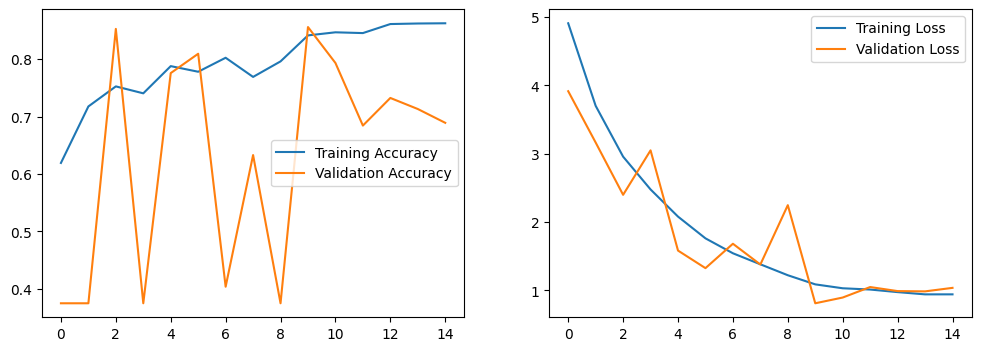

In [14]:
#new metrics
#new graphs
import matplotlib.pyplot as plt

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
test_generator.reset()
pred_probs = model_en.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
              precision    recall  f1-score   support

      NORMAL       0.79      0.85      0.81       234
   PNEUMONIA       0.90      0.86      0.88       390

    accuracy                           0.86       624
   macro avg       0.84      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



In [ ]:
import numpy as np

# Get predicted probabilities (sigmoid outputs)
test_generator.reset()
y_pred_probs = model_en.predict(test_generator)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


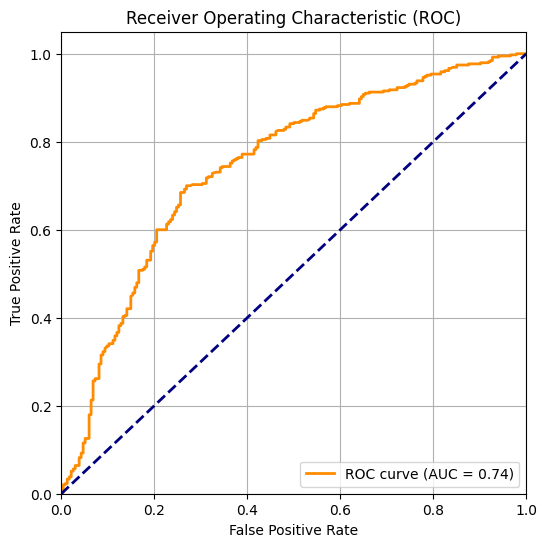

In [31]:
from sklearn.metrics import roc_curve, auc

# Get the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

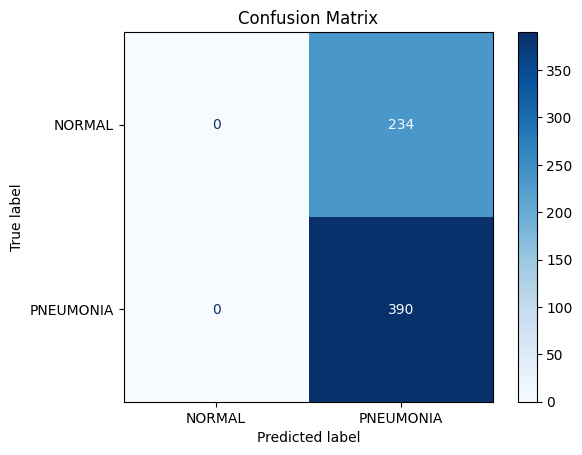

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

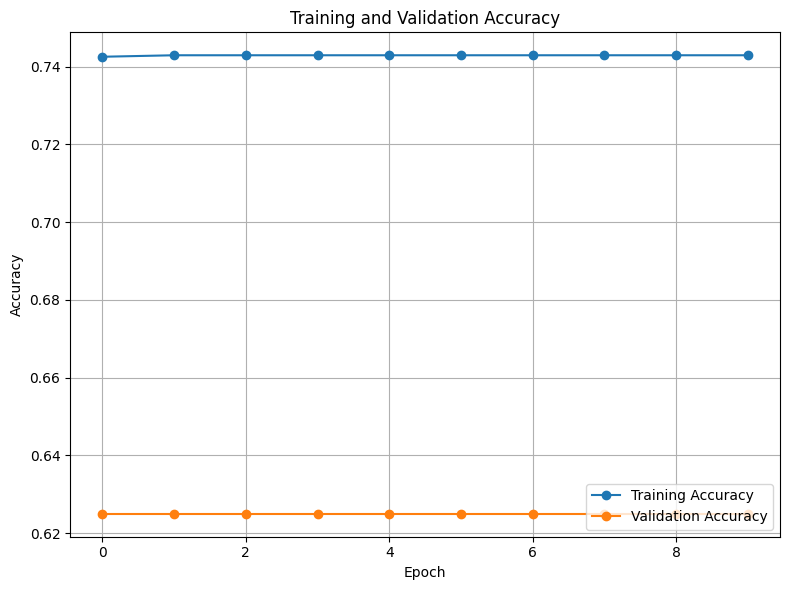

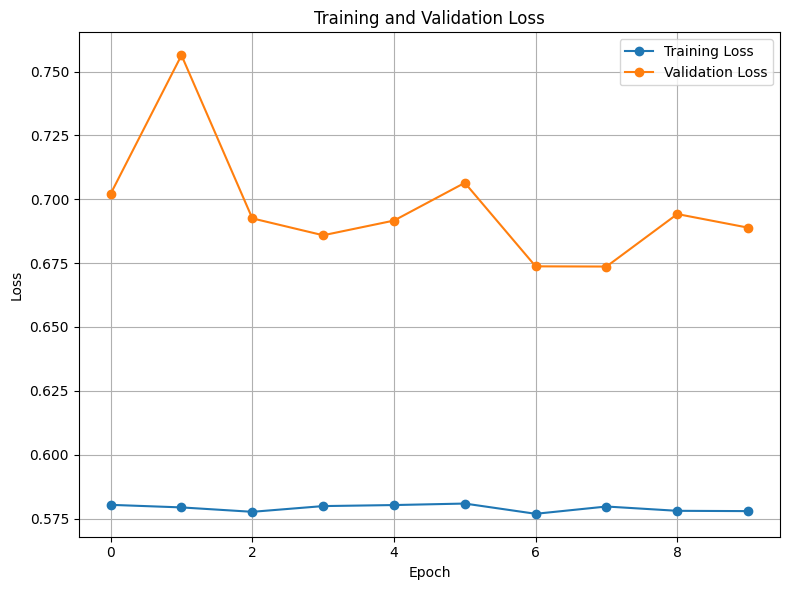

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


Try #2

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Critical!
    rotation_range=10,  # Reduced augmentation
    horizontal_flip=True
)

In [28]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def build_efficientnet():
    # 1. Base model with proper input specification
    efficient_base = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Removed drop_connect_rate
    )
    
    # 2. Selective unfreezing (better than full freezing)
    for layer in efficient_base.layers[:180]:
        layer.trainable = False
    for layer in efficient_base.layers[180:]:
        layer.trainable = True
    
    # 3. Enhanced classification head
    x = efficient_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, 
              activation='relu',
              kernel_regularizer=l2(0.001))(x)  # Added L2 regularization
    x = Dropout(0.3)(x)  # Increased dropout
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=efficient_base.input, outputs=outputs)
    
    # 4. Custom optimizer configuration
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Initialize model
model_en = build_efficientnet()

# Class weights
class_weights = {
    0: len(train_generator.classes)/np.bincount(train_generator.classes)[0],
    1: len(train_generator.classes)/np.bincount(train_generator.classes)[1]
}

# Training
history = model_en.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.5342 - loss: 1.8449 - precision: 0.7479 - recall: 0.5629 - val_accuracy: 0.6250 - val_loss: 1.0745 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.5935 - loss: 1.6757 - precision: 0.8251 - recall: 0.5702 - val_accuracy: 0.3750 - val_loss: 1.0722 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.6337 - loss: 1.4796 - precision: 0.8649 - recall: 0.6037 - val_accuracy: 0.6474 - val_loss: 1.0218 - val_precision: 0.9722 - val_recall: 0.4487
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.6426 - loss: 1.3997 - precision: 0.8694 - recall: 0.6108 - val_accuracy: 0.7596 - val_loss: 0.9635 - val_precision: 0.7239 - val_recall: 0.9949
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.6445 - loss: 1.3744 - precision: 0.8652 - recall: 0.6215 - val_accuracy: 0.3750 -

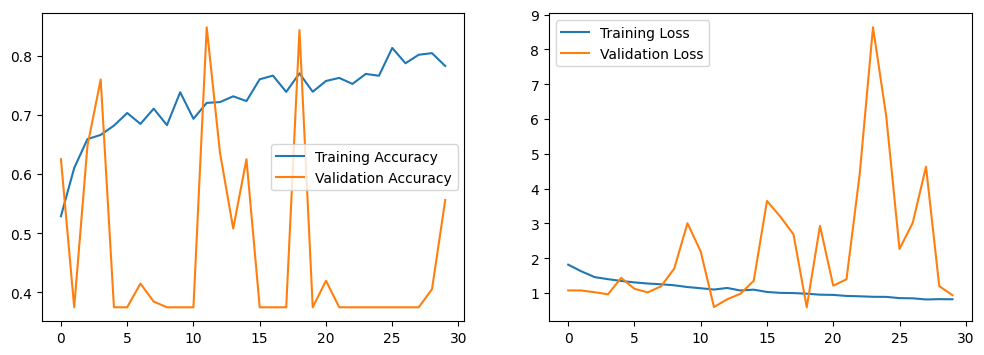

In [29]:
#new metrics
#new graphs
import matplotlib.pyplot as plt

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
test_generator.reset()
pred_probs = model_en.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
              precision    recall  f1-score   support

      NORMAL       0.46      0.99      0.63       234
   PNEUMONIA       0.97      0.30      0.46       390

    accuracy                           0.56       624
   macro avg       0.72      0.64      0.54       624
weighted avg       0.78      0.56      0.52       624



In [31]:
import numpy as np

# Get predicted probabilities (sigmoid outputs)
test_generator.reset()
y_pred_probs = model_en.predict(test_generator)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


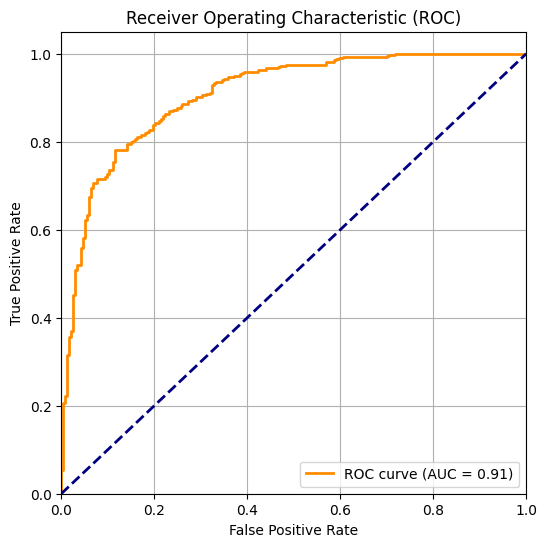

In [32]:
from sklearn.metrics import roc_curve, auc

# Get the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

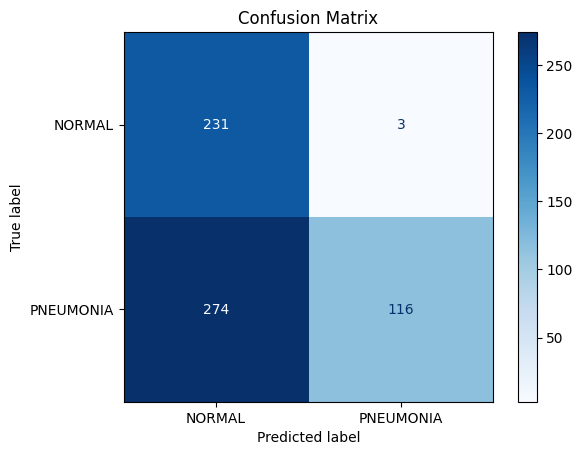

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

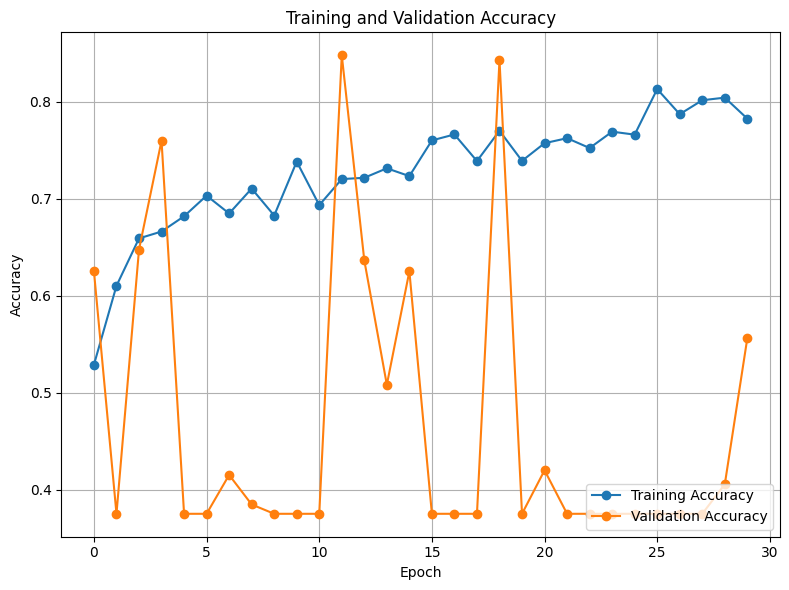

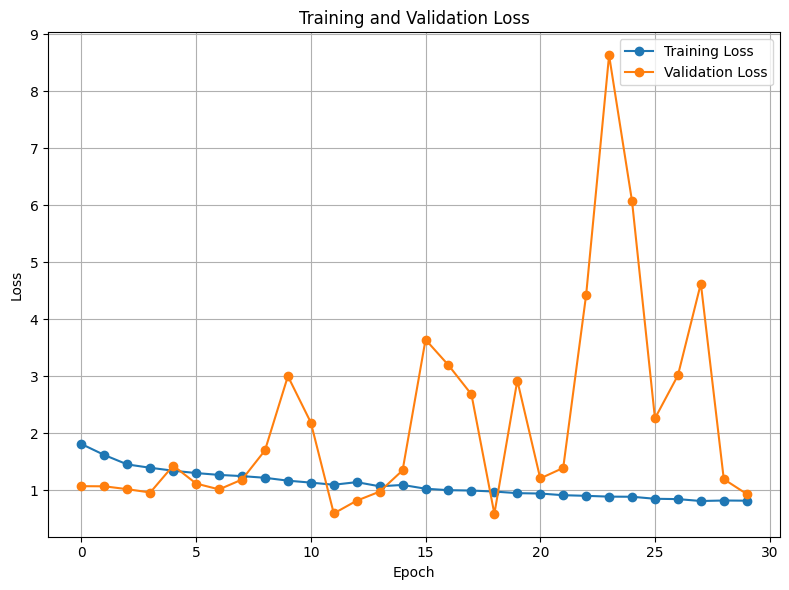

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


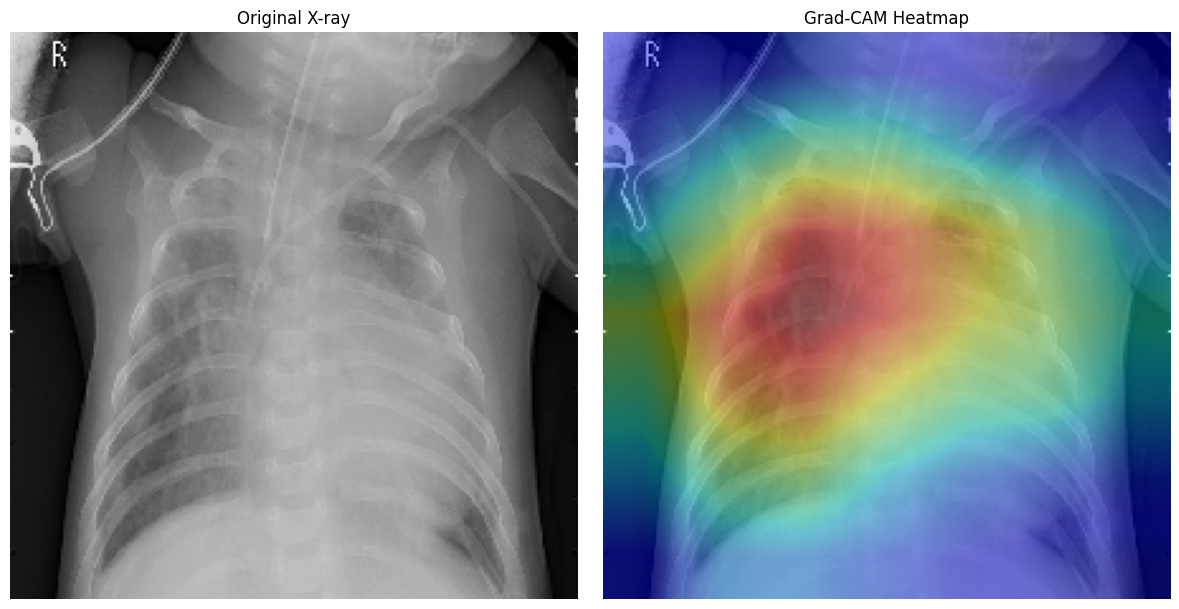

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def generate_grad_cam(model, img_array, layer_name='top_activation'):
    """Generate Grad-CAM heatmap for EfficientNetB0"""
    # 1. Create gradient model
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # 2. Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0]  # Binary classification
        
    # 3. Get gradients and importance weights
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    # 4. Generate heatmap
    conv_outputs = conv_outputs[0].numpy()
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def plot_grad_cam(image_path, model, target_size=(224, 224)):
    # Load and preprocess image (EfficientNet-specific)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.applications.efficientnet.preprocess_input(
        tf.keras.preprocessing.image.img_to_array(img)[np.newaxis, ...]
    )
    
    # Generate heatmap
    heatmap = generate_grad_cam(model, img_array)
    
    # Resize heatmap
    heatmap = tf.image.resize(heatmap[..., np.newaxis], target_size).numpy().squeeze()
    
    # Prepare image for display
    img_display = img_array[0].copy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title("Original X-ray")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_display)
    plt.imshow(heatmap, cmap='jet', alpha=0.4, vmin=0, vmax=1)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_grad_cam('archive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg', model_en)
#ONLY works for image 6 and not even correct heatmap

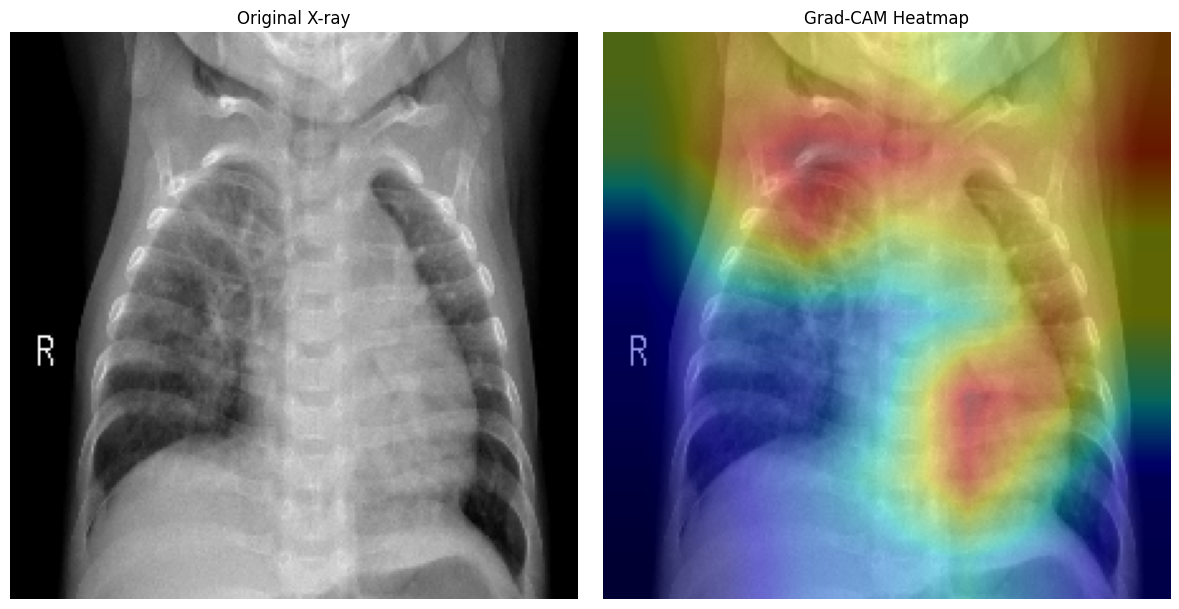

In [52]:
plot_grad_cam('archive/chest_xray/test/PNEUMONIA/person127_bacteria_604.jpeg', model_en)

In [60]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def build_efficientnet():
    # 1. Base model with proper input specification
    efficient_base = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Removed drop_connect_rate
    )
    
    # 2. Selective unfreezing (better than full freezing)
    for layer in efficient_base.layers[:180]:
        layer.trainable = False
    for layer in efficient_base.layers[180:]:
        layer.trainable = True
    
    # 3. Enhanced classification head
    x = efficient_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, 
              activation='relu',
              kernel_regularizer=l2(0.001))(x)  # Added L2 regularization
    x = Dropout(0.3)(x)  # Increased dropout
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=efficient_base.input, outputs=outputs)
    
    # 4. Custom optimizer configuration
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Initialize model
model_en = build_efficientnet()

# Class weights
class_weights = {
    0: len(train_generator.classes)/np.bincount(train_generator.classes)[0],
    1: len(train_generator.classes)/np.bincount(train_generator.classes)[1]
}

# Training
history = model_en.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weights
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.5058 - loss: 1.8405 - precision: 0.7615 - recall: 0.4888 - val_accuracy: 0.3750 - val_loss: 1.1331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.6076 - loss: 1.6057 - precision: 0.8256 - recall: 0.6003 - val_accuracy: 0.6250 - val_loss: 1.0463 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.6760 - loss: 1.4659 - precision: 0.8412 - recall: 0.6987 - val_accuracy: 0.7580 - val_loss: 1.0030 - val_precision: 0.9650 - val_recall: 0.6359
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.6869 - loss: 1.4178 - precision: 0.8679 - recall: 0.6774 - val_accuracy: 0.6250 - val_loss: 1.1749 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7014 - loss: 1.3961 - precision: 0.8571 - recall: 0.7191 - val_accuracy: 0.6250 -

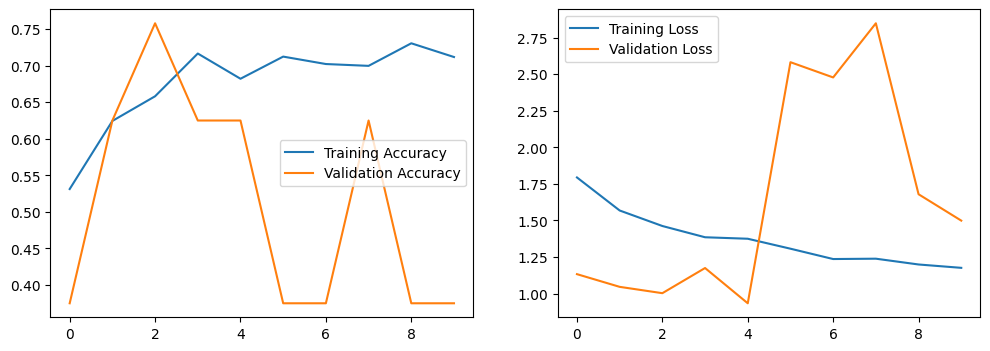

In [61]:
#new metrics
#new graphs
import matplotlib.pyplot as plt

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

plot_metrics(history)



In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
test_generator.reset()
pred_probs = model_en.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step 
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [63]:
import numpy as np

# Get predicted probabilities (sigmoid outputs)
test_generator.reset()
y_pred_probs = model_en.predict(test_generator)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 928ms/step


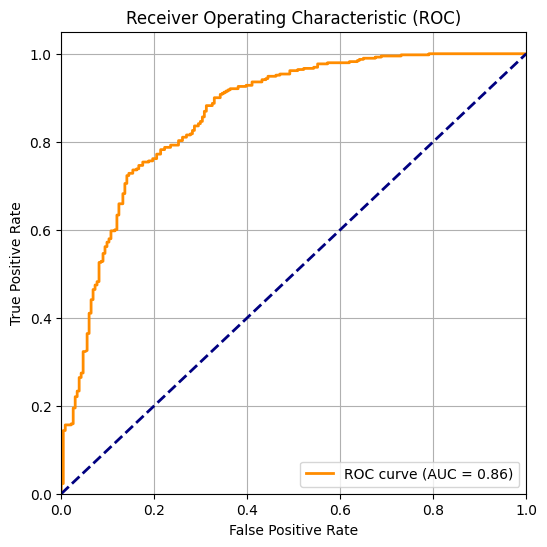

In [64]:
from sklearn.metrics import roc_curve, auc

# Get the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<Figure size 600x600 with 0 Axes>

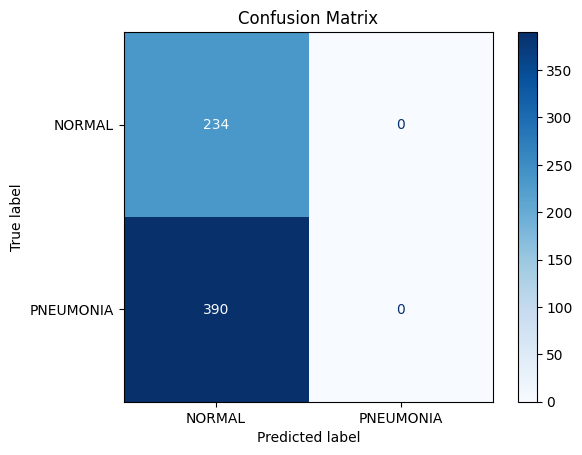

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


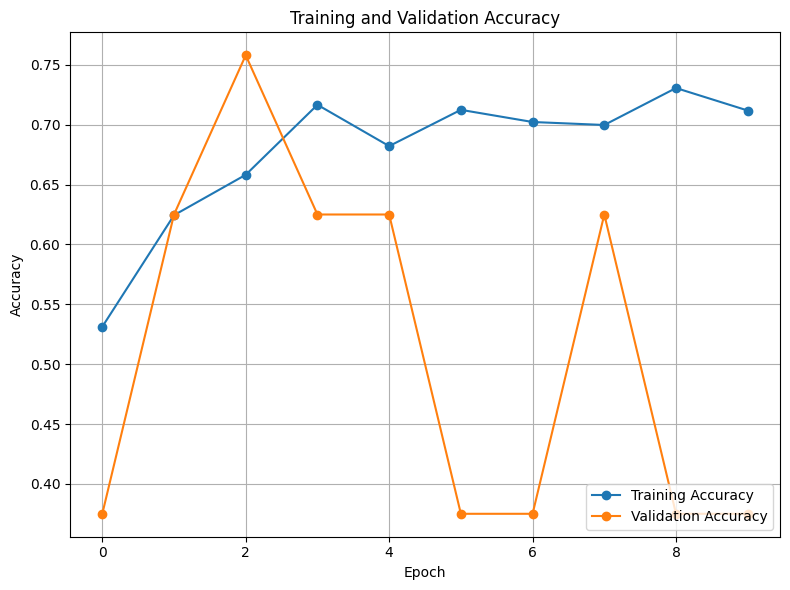

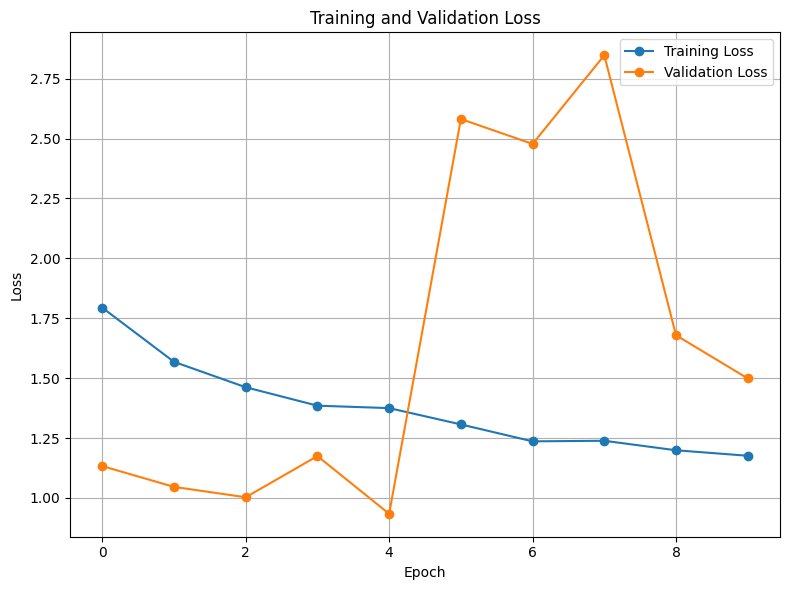

In [66]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1690']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


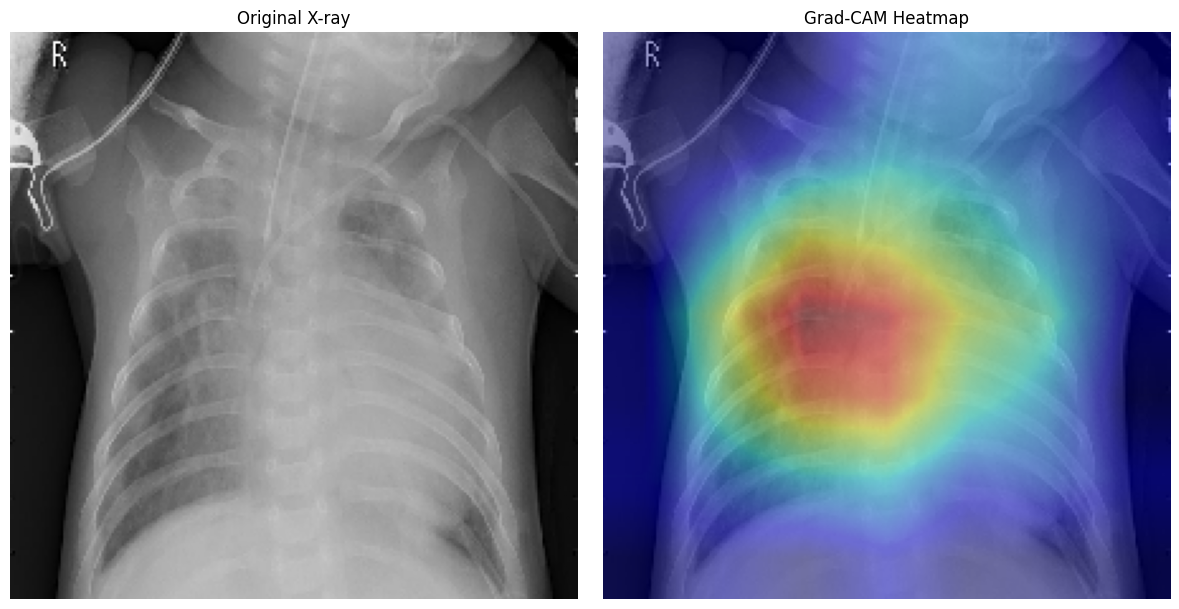

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def generate_grad_cam(model, img_array, layer_name='top_activation'):
    """Generate Grad-CAM heatmap for EfficientNetB0"""
    # 1. Create gradient model
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # 2. Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0]  # Binary classification
        
    # 3. Get gradients and importance weights
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    # 4. Generate heatmap
    conv_outputs = conv_outputs[0].numpy()
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def plot_grad_cam(image_path, model, target_size=(224, 224)):
    # Load and preprocess image (EfficientNet-specific)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.applications.efficientnet.preprocess_input(
        tf.keras.preprocessing.image.img_to_array(img)[np.newaxis, ...]
    )
    
    # Generate heatmap
    heatmap = generate_grad_cam(model, img_array)
    
    # Resize heatmap
    heatmap = tf.image.resize(heatmap[..., np.newaxis], target_size).numpy().squeeze()
    
    # Prepare image for display
    img_display = img_array[0].copy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title("Original X-ray")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_display)
    plt.imshow(heatmap, cmap='jet', alpha=0.4, vmin=0, vmax=1)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_grad_cam('archive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg', model_en)
#ONLY works for image 6 and not sure if correct heatmap
